In [ ]:
pip install graphviz matplotlib


In [ ]:
!pip uninstall torch_geometric -y

# Install torch_geometric with the correct dependencies for your PyTorch version and CUDA availability
# Replace <your_cuda_version> with your CUDA version (e.g., cu117, cu118, cu121) or leave blank for CPU-only
# Refer to the PyTorch Geometric installation guide for the correct command:
# https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html

# Example for PyTorch 2.0.0 and CUDA 11.7
# !pip install torch_geometric torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

# If using a CPU-only version of PyTorch:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import shutil

# Check if the mount point exists and is not empty, then clear it
mountpoint = '/content/drive/'
if os.path.exists(mountpoint) and os.path.isdir(mountpoint) and os.listdir(mountpoint):
    print(f"Clearing mount point: {mountpoint}")
    for item in os.listdir(mountpoint):
        item_path = os.path.join(mountpoint, item)
        try:
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            else:
                os.remove(item_path)
        except Exception as e:
            print(f"Error removing {item_path}: {e}")

drive.mount(mountpoint)

Clearing mount point: /content/drive/
Mounted at /content/drive/


# Playing with Data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
bold_file = '/content/drive/MyDrive/Data/sub-002S0295/func/sub-002S0295_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confounds_file = '/content/drive/MyDrive/Data/sub-002S0295/func/sub-002S0295_task-rest_run-02_desc-confounds_timeseries.tsv'

In [ ]:
pip install nilearn

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets, image

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
atlas_filename = atlas.maps
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
# Load the confounds file using pandas
confounds_df = pd.read_csv(confounds_file, sep='\t')

# Handle NaN and inf values in the confounds data
# Replace inf with NaN first for easier imputation
confounds_df = confounds_df.replace([np.inf, -np.inf], np.nan)

# Use KNNImputer to fill missing values. You can adjust n_neighbors.
imputer = KNNImputer(n_neighbors=5)
confounds_cleaned = imputer.fit_transform(confounds_df)

# Convert the cleaned confounds back to a DataFrame if needed, though nilearn can usually handle numpy arrays
confounds_cleaned_df = pd.DataFrame(confounds_cleaned, columns=confounds_df.columns)

# Load time series (after confound regression)
time_series = masker.fit_transform(bold_file, confounds=confounds_cleaned_df)

In [ ]:
fc_matrix = np.corrcoef(time_series.T)  # shape: (n_regions, n_regions)
print(time_series.shape)

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.plot(time_series[:, i], label=f'ROI {i}')
plt.legend()
plt.title("ROI Time Series")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal")
plt.show()

In [ ]:
from nilearn import plotting
mean_bold_img = image.mean_img(bold_file)

plotting.plot_roi(atlas_filename, bg_img=mean_bold_img, title='Check Atlas Alignment')


In [ ]:

plt.figure(figsize=(10, 8))
plt.imshow(fc_matrix, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Correlation Coefficient')
plt.title('Functional Connectivity Matrix')
plt.xlabel('ROI')
plt.ylabel('ROI')
plt.show()

In [ ]:
confounds = pd.read_csv(confounds_file, sep='\t')
confound_vars = confounds[[
    'trans_x', 'trans_y', 'trans_z',
    'rot_x', 'rot_y', 'rot_z',
    'csf', 'white_matter'
]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs if any

# Set TR of your fMRI data (seconds)
TR = 2.0

# Create masker with standardization and bandpass filtering
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize=True,     # z-score each ROI time series
    t_r=TR,
    low_pass=0.1,         # upper freq cutoff (Hz)
    high_pass=0.01,       # lower freq cutoff (Hz)
    smoothing_fwhm=8      # optional spatial smoothing
)

# Extract cleaned time series with confound regression and filtering
time_series = masker.fit_transform(bold_file, confounds=confound_vars)

print(f"Extracted time series shape: {time_series.shape}")  # (n_timepoints, n_rois)

# Compute functional connectivity matrix (correlation)
fc_matrix = np.corrcoef(time_series.T)  # shape: (n_rois, n_rois)

# Visualize FC matrix
plt.figure(figsize=(8,6))
plt.imshow(fc_matrix, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.title('Functional Connectivity Matrix')
plt.show()

# Plot histogram of correlations (upper triangle)
fc_values = fc_matrix[np.triu_indices_from(fc_matrix, k=1)]
plt.figure()
plt.hist(fc_values, bins=50, color='skyblue')
plt.title('Distribution of FC values')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def sliding_window_fc(time_series, window_size, step_size):
    n_timepoints, n_rois = time_series.shape
    dFC_matrices = []

    for start in range(0, n_timepoints - window_size + 1, step_size):
        window_data = time_series[start:start+window_size, :]
        corr_matrix = np.corrcoef(window_data.T)
        dFC_matrices.append(corr_matrix)

    return np.array(dFC_matrices)  # shape: (n_windows, n_rois, n_rois)

# TADPOLE IDs


In [ ]:
ids_finished = []
ids_to_keep = ['002S0295',
'002S0413',
'002S0685',
'002S0729',
'002S1155',
'002S1261',
'002S1268',
'002S1280',
'002S2010',
'002S2043',
'002S2073',
'002S4171',
'002S4213',
'002S4219',
'002S4225',
'002S4229',
'002S4237',
'002S4251',
'002S4262',
'002S4264',
'002S4270',
'002S4447',
'002S4473',
'002S4521',
'002S4654',
'002S4746',
'002S4799',
'002S5018',
'002S5178',
'002S5230',
'002S5256',
'003S0908',
'003S1074',
'003S1122',
'006S0498',
'006S0731',
'006S4150',
'006S4153',
'006S4192',
'006S4346',
'006S4357',
'006S4363',
'006S4449',
'006S4485',
'006S4515',
'006S4546',
'006S4679',
'006S4713',
'006S4867',
'006S4960',
'006S5153',
'010S4345',
'010S4442',
'011S0021',
'011S4105',
'011S4278',
'011S4547',
'011S4827',
'011S4893',
'012S4012',
'012S4026',
'012S4094',
'012S4128',
'012S4188',
'012S4545',
'012S4643',
'012S4849',
'012S4987',
'012S5121',
'012S5157',
'012S5195',
'012S5213',
'013S1186',
'013S2324',
'013S2389',
'013S4268',
'013S4395',
'013S4579',
'013S4580',
'013S4595',
'013S4616',
'013S4791',
'013S4917',
'013S4985',
'013S5071',
'013S5137',
'013S5171',
'014S2308',
'014S4401',
'014S4576',
'018S2133',
'018S2138',
'018S2155',
'018S2180',
'018S4257',
'018S4313',
'018S4349',
'018S4399',
'018S4400',
'018S4597',
'018S4696',
'018S4733',
'018S4809',
'018S4868',
'018S4889',
'018S5240',
'018S5250',
'018S5262',
'019S4252',
'019S4285',
'019S4293',
'019S4367',
'019S4477',
'019S4548',
'019S4549',
'019S4680',
'019S4835',
'019S5012',
'019S5019',
'019S5242',
'020S5140',
'020S5203',
'022S2263',
'022S2379',
'022S5004',
'023S1190',
'024S4084',
'024S4674',
'024S5290',
'031S2018',
'031S2022',
'031S2233',
'031S4005',
'031S4021',
'031S4024',
'031S4029',
'031S4032',
'031S4042',
'031S4149',
'031S4194',
'031S4203',
'031S4218',
'031S4474',
'031S4476',
'031S4496',
'031S4590',
'031S4721',
'031S4947',
'032S0677',
'032S1169',
'032S2119',
'032S4277',
'032S4429',
'032S5289',
'035S0156',
'035S0555',
'035S4114',
'035S4414',
'035S4464',
'035S4785',
'037S0150',
'037S0303',
'037S0377',
'037S0454',
'037S4028',
'037S4030',
'037S4071',
'037S4214',
'037S4302',
'037S4308',
'037S4410',
'037S4706',
'041S0679',
'041S1418',
'041S4037',
'041S4051',
'041S4143',
'041S4200',
'041S4271',
'041S4427',
'041S4510',
'041S4513',
'041S4874',
'041S4876',
'041S4974',
'041S5026',
'041S5078',
'041S5097',
'041S5100',
'041S5141',
'041S5253',
'053S0919',
'053S2357',
'053S2396',
'053S4557',
'053S4578',
'053S4661',
'053S4813',
'053S5070',
'053S5202',
'053S5208',
'053S5272',
'053S5287',
'053S5296',
'068S0210',
'068S0473',
'068S0802',
'068S2184',
'068S2187',
'068S2315',
'068S4061',
'068S4067',
'068S4332',
'068S4340',
'068S4424',
'068S4431',
'070S4856',
'070S5040',
'082S2121',
'082S4224',
'082S4428',
'082S5278',
'082S5282',
'100S0069',
'100S0296',
'100S1286',
'100S2351',
'100S4469',
'100S4512',
'100S4556',
'100S5075',
'100S5091',
'100S5096',
'100S5102',
'100S5106',
'100S5280',
'114S0416',
'114S2392',
'114S4404',
'114S5047',
'114S5234',
'116S0382',
'116S4043',
'116S4199',
'116S4453',
'116S4483',
'116S4855',
'129S0778',
'129S4073',
'129S4220',
'129S4287',
'129S4369',
'129S4371',
'129S4396',
'129S4422',
'130S0969',
'130S2373',
'130S2391',
'130S2403',
'130S4250',
'130S4294',
'130S4343',
'130S4352',
'130S4405',
'130S4415',
'130S4417',
'130S4468',
'130S4542',
'130S4589',
'130S4605',
'130S4641',
'130S4660',
'130S4730',
'130S4817',
'130S4883',
'130S4925',
'130S4971',
'130S4982',
'130S4984',
'130S4990',
'130S4997',
'130S5006',
'130S5059',
'130S5142',
'130S5175',
'130S5231',
'130S5258',
'131S5138',
'131S5148',
'136S0107',
'136S0186',
'136S4189',
'136S4269',
'136S4408',
'136S4433',
'136S4517',
'141S0767',
'141S1052',
'141S1378',
'141S2333',
'141S4160',
'941S4036',
'941S4100',
'941S4187',
'941S4292',
'941S4365',
'941S5193']

# Calculating FC Matrices

In [ ]:
bold_file = '/content/drive/MyDrive/Data/sub-002S0295/func/sub-002S0295_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confounds_file = '/content/drive/MyDrive/Data/sub-002S0295/func/sub-002S0295_task-rest_run-02_desc-confounds_timeseries.tsv'

id = '002S0295'
bold_filesname = '/content/drive/MyDrive/Data/sub-' + id +'/func/sub-' + id +'_task-rest_run-0' + i + '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
print(bold_filesname)

In [ ]:
pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 55.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from pathlib import Path
import os
import json

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
atlas_filename = atlas.maps
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
labels = atlas.labels
labels_array = np.array(labels)

drive_folder = '/content/drive/MyDrive/Data/Updated FC Matrices'
output_dir = Path(drive_folder)
output_dir.mkdir(parents=True, exist_ok=True)
for id in ids_to_keep:
    run_number = 1

    while True:
        bold_file = Path(f"/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
        confounds_file = Path(f'/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_desc-confounds_timeseries.tsv')

        # Construct JSON file path by replacing suffix
        json_file = bold_file.with_name(
            bold_file.name.replace('_desc-preproc_bold.nii.gz', '_desc-preproc_bold.json')
        )

        if bold_file.exists() and json_file.exists():
            # --- Read TR from JSON ---
            with open(json_file, 'r') as f:
                metadata = json.load(f)
                TR = metadata.get("RepetitionTime", None)

            if TR is None:
                print(f"⚠️ RepetitionTime not found in {json_file}")
                break
            else:
                print(f"✅ RepetitionTime found in {json_file}: {TR}")
            confounds = pd.read_csv(confounds_file, sep='\t')
            confound_vars = confounds[[
                'trans_x', 'trans_y', 'trans_z',
                'rot_x', 'rot_y', 'rot_z',
                'csf', 'white_matter'
            ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs

            masker = NiftiLabelsMasker(
                labels_img=atlas_filename,
                standardize=True,
                t_r=TR,
                low_pass=0.1,
                high_pass=0.01,
                smoothing_fwhm=8
            )

            time_series = masker.fit_transform(bold_file, confounds=confound_vars)
            fc_matrix = np.corrcoef(time_series.T)

            filename = f'sub-{id}_run-0{run_number}_fc_matrix.npz'
            filepath = os.path.join(output_dir, filename)
            np.savez(filepath, fc_matrix=fc_matrix, labels=labels_array)

            print(f"✅ Saved FC matrix for sub-{id}, run {run_number}, TR={TR:.2f}s -> {filepath}")

            run_number += 1

        else:
            print(f"❌ Missing: {bold_file} or {json_file}")
            break


[fetch_atlas_schaefer_2018] Dataset found in /root/nilearn_data/schaefer_2018

✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-04_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-05_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-06_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-07_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-08_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4094, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4094_run-09_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4128, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4128, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


✅ Saved FC matrix for sub-012S4128, run 3, TR=6.02s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4128, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-04_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4128, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-05_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4128, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4128_run-06_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-04_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-05_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-06_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4188, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4188_run-07_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4545, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4545_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4545, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4545_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4545, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4545_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4545, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4545_run-04_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4545, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4545_run-05_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-04_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-05_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-06_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-07_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-08_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4643, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4643_run-09_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4849, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4849_run-01_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4849, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4849_run-02_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4849, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4849_run-03_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


✅ Saved FC matrix for sub-012S4849, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/sub-012S4849_run-04_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4987/func/sub-012S4987_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3


/tmp/ipython-input-5-2376277316.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')  # Handle NaNs


KeyboardInterrupt: 

In [ ]:
npz_file = np.load('/content/drive/MyDrive/Data/FC Matrices/sub-002S0295_run-01_fc_matrix.npz')
fc_matrix = npz_file['arr_0']
labels_array = npz_file['arr_1']
plt.figure(figsize=(8,6))
plt.imshow(fc_matrix, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.title('Functional Connectivity Matrix')
plt.show()

fc_values = fc_matrix[np.triu_indices_from(fc_matrix, k=1)]
plt.figure()
plt.hist(fc_values, bins=50, color='skyblue')
plt.title('Distribution of FC values')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import os
#Creating new folders in google drive

for id in ids_to_keep:

    folder_path = f'/content/drive/MyDrive/Data/FC Matrices/sub-{id}'

      # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    print(f"Folder created at: {folder_path}")


In [ ]:
import shutil


for id in ids_to_keep:
    run_number = 1
    while True:

        source_file = f'/content/drive/MyDrive/Data/FC Matrices/sub-{id}_run-0{run_number}_fc_matrix.npz'
        destination_path = f'/content/drive/MyDrive/Data/FC Matrices/sub-{id}/sub-{id}_run-0{run_number}_fc_matrix.npz'

        if os.path.exists(source_file):
            shutil.move(source_file, destination_path)
            print(f"File copied from {source_file} to {destination_path}")
            run_number += 1
        else:
            print(f"File not found: {source_file}")
            break

# Creating DFC Matrices


In [ ]:
from pathlib import Path
import os
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets, image

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
atlas_filename = atlas.maps
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
labels = atlas.labels
labels_array = np.array(labels)

drive_folder = '/content/drive/MyDrive/Data/DFC Matrices'
output_dir = Path(drive_folder)
output_dir.mkdir(parents=True, exist_ok=True)
for id in ids_to_keep:
    run_number = 1

    while True:
      bold_file = Path(f"/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
      confounds_file = Path(f'/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_desc-confounds_timeseries.tsv')



      if bold_file.exists():
          confounds = pd.read_csv(confounds_file, sep='\t')
          confound_vars = confounds[[
              'trans_x', 'trans_y', 'trans_z',
              'rot_x', 'rot_y', 'rot_z',
              'csf', 'white_matter'
          ]].fillna(method='bfill').fillna(method='ffill')

          TR = 2.0

          masker = NiftiLabelsMasker(
              labels_img=atlas_filename,
              standardize=True,
              t_r=TR,
              low_pass=0.1,
              high_pass=0.01,
              smoothing_fwhm=8
          )

          time_series = masker.fit_transform(bold_file, confounds=confound_vars)

          print(f"Extracted time series shape: {time_series.shape}")


          dfc_matrix = compute_dynamic_fc_matrix(time_series, window_size= 30, step_size= 5)
          filename = f'sub-{id}_run-0{run_number}_dfc_matrix'
          filepath = os.path.join(output_dir, filename)
          np.savez(filepath, dfc_matrix, labels_array)

          run_number += 1
      else:
          print(f"Missing: {bold_file}")
          break

In [ ]:
import os
#Creating new folders in google drive

for id in ids_to_keep:

    folder_path = f'/content/drive/MyDrive/Data/DFC Matrices/sub-{id}'

      # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    print(f"Folder created at: {folder_path}")

In [ ]:
import shutil


for id in ids_to_keep:
    run_number = 1
    while True:

        source_file = f'/content/drive/MyDrive/Data/DFC Matrices/sub-{id}_run-0{run_number}_dfc_matrix.npz'
        destination_path = f'/content/drive/MyDrive/Data/DFC Matrices/sub-{id}/sub-{id}_run-0{run_number}_dfc_matrix.npz'

        if os.path.exists(source_file):
            shutil.move(source_file, destination_path)
            print(f"File copied from {source_file} to {destination_path}")
            run_number += 1
        else:
            print(f"File not found: {source_file}")
            break

In [ ]:
import random
from sklearn.model_selection import train_test_split

# Split (80% train, 20% test)
train_ids, test_ids = train_test_split(ids_to_keep, test_size=0.2, random_state=42)

print("Train:", train_ids)
print("Test:", test_ids)

In [ ]:
import shutil


for id in train_ids:
    src = f'/content/drive/MyDrive/Data/DFC Matrices/sub-{id}'
    dst = '/content/drive/MyDrive/Data/DFC Matrices/Training Dataset/'

    shutil.move(src, dst)

In [ ]:
import shutil


for id in test_ids:
    src = f'/content/drive/MyDrive/Data/DFC Matrices/sub-{id}'
    dst = '/content/drive/MyDrive/Data/DFC Matrices/Testing Dataset/'

    shutil.move(src, dst)

In [ ]:
import numpy as np
import os

dfc_dir = "/content/drive/MyDrive/1. Dr. Siadat/Data/DFC Matrices/Training Dataset/"
t_values = []

# Check first 10 .npz files to see if T is consistent
count = 0
for root, dirs, files in os.walk(dfc_dir):
    for file in files:
        if file.endswith(".npz") and count < 1000:
            npz_path = os.path.join(root, file)
            data = np.load(npz_path)
            key = list(data.keys())[0]
            dfc_array = data[key]
            t_values.append(dfc_array.shape[0])
            print(f"{file}: T = {dfc_array.shape[0]}")
            count += 1
    if count >= 1000:
        break

print(f"\nT values found: {t_values}")
print(f"All T values are the same: {len(set(t_values)) == 1}")

sub-002S0295_run-01_dfc_matrix.npz: T = 23
sub-002S0295_run-02_dfc_matrix.npz: T = 23
sub-002S0295_run-01_dfc_matrix_CN.npz: T = 23
sub-002S0295_run-02_dfc_matrix_CN.npz: T = 23
sub-002S0413_run-01_dfc_matrix.npz: T = 34
sub-002S0413_run-02_dfc_matrix.npz: T = 35
sub-002S0413_run-03_dfc_matrix.npz: T = 23
sub-002S0413_run-04_dfc_matrix.npz: T = 23
sub-002S0413_run-05_dfc_matrix.npz: T = 23
sub-002S0413_run-01_dfc_matrix_CN.npz: T = 34
sub-002S0413_run-02_dfc_matrix_CN.npz: T = 35
sub-002S0413_run-03_dfc_matrix_CN.npz: T = 23
sub-002S0413_run-04_dfc_matrix_CN.npz: T = 23
sub-002S0413_run-05_dfc_matrix_CN.npz: T = 23
sub-002S0685_run-01_dfc_matrix.npz: T = 23
sub-002S0685_run-01_dfc_matrix_CN.npz: T = 23
sub-002S1155_run-01_dfc_matrix.npz: T = 34
sub-002S1155_run-02_dfc_matrix.npz: T = 34
sub-002S1155_run-03_dfc_matrix.npz: T = 35
sub-002S1155_run-04_dfc_matrix.npz: T = 23
sub-002S1155_run-05_dfc_matrix.npz: T = 23
sub-002S1155_run-06_dfc_matrix.npz: T = 23
sub-002S1155_run-01_dfc_matrix

KeyboardInterrupt: 

In [1]:
import os
import google.colab.drive as drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 57.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from pathlib import Path
import os
import json

# Load Schaefer 100 ROI atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
atlas_filename = atlas.maps
labels = atlas.labels
labels_array = np.array(labels)

# Output directory
drive_folder = '/content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices'
output_dir = Path(drive_folder)
output_dir.mkdir(parents=True, exist_ok=True)

# Subject IDs to process

# Loop through subjects
for id in ids_to_keep:
    run_number = 1

    while True:
        # Define paths
        bold_file = Path(f"/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
        confounds_file = Path(f"/content/drive/MyDrive/Preprocessed Subjects/sub-{id}/func/sub-{id}_task-rest_run-0{run_number}_desc-confounds_timeseries.tsv")
        json_file = bold_file.with_name(
            bold_file.name.replace('_desc-preproc_bold.nii.gz', '_desc-preproc_bold.json')
        )

        if bold_file.exists() and json_file.exists():
            # Load TR from JSON
            with open(json_file, 'r') as f:
                metadata = json.load(f)
                TR = metadata.get("RepetitionTime", None)

            if TR is None:
                print(f"⚠️ RepetitionTime not found in {json_file}")
                break
            else:
                print(f"✅ RepetitionTime found in {json_file}: {TR} s")

            # Load confounds
            confounds = pd.read_csv(confounds_file, sep='\t')
            confound_vars = confounds[[
                'trans_x', 'trans_y', 'trans_z',
                'rot_x', 'rot_y', 'rot_z',
                'csf', 'white_matter'
            ]].fillna(method='bfill').fillna(method='ffill')

            # Initialize masker
            masker = NiftiLabelsMasker(
                labels_img=atlas_filename,
                standardize=True,
                t_r=TR,
                low_pass=0.1,
                high_pass=0.01,
                smoothing_fwhm=8
            )

            # Extract time series
            time_series = masker.fit_transform(bold_file, confounds=confound_vars)
            n_timepoints, n_rois = time_series.shape

            # === Dynamic window & step size based on TR ===
            desired_window_sec = 30  # e.g., 30-second window
            desired_step_sec = 5     # e.g., 5-second step

            window_size = int(desired_window_sec / TR)
            step_size = int(desired_step_sec / TR)

            if window_size < 10:
                print(f"⚠️ Window size too small for sub-{id}, run {run_number}. Skipping.")
                break

            windows = []
            for start in range(0, n_timepoints - window_size + 1, step_size):
                end = start + window_size
                window_ts = time_series[start:end, :]
                window_fc = np.corrcoef(window_ts.T)
                windows.append(window_fc)

            if len(windows) == 0:
                print(f"⚠️ Not enough timepoints for dynamic FC for sub-{id}, run {run_number}")
                break

            dynamic_fc_matrices = np.stack(windows)  # (n_windows, n_rois, n_rois)

            # Save
            filename = f"sub-{id}_run-0{run_number}_dynamic_fc_matrix.npz"
            filepath = os.path.join(output_dir, filename)
            np.savez(filepath, dynamic_fc=dynamic_fc_matrices, labels=labels_array)

            print(f"✅ Saved dynamic FC for sub-{id}, run {run_number}, TR={TR:.2f}s -> {filepath}")
            run_number += 1

        else:
            print(f"❌ Missing: {bold_file} or {json_file}")
            break

[fetch_atlas_schaefer_2018] Dataset found in /root/nilearn_data/schaefer_2018

✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S0295/func/sub-002S0295_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S0295, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S0413/func/sub-002S0413_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S0413, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S0413_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S0413/func/sub-002S0413_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S0413, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S0685/func/sub-002S0685_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S0685, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S0729/func/sub-002S0729_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S0729, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1155/func/sub-002S1155_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1155, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1155_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1155/func/sub-002S1155_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1155, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1155_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1155/func/sub-002S1155_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02302 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08301473408937454 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S1155, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1261/func/sub-002S1261_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1261, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1261_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1261/func/sub-002S1261_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1261, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1261_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1261/func/sub-002S1261_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S1261, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1268/func/sub-002S1268_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1268, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1268_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1268/func/sub-002S1268_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S1268, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1280/func/sub-002S1280_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S1280, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S1280_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S1280/func/sub-002S1280_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S1280, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S2010/func/sub-002S2010_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S2010, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S2043/func/sub-002S2043_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S2043, run 1, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S2043_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S2043/func/sub-002S2043_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S2043, run 2, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S2043_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S2043/func/sub-002S2043_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S2043, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S2073/func/sub-002S2073_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S2073, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4171/func/sub-002S4171_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4171, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4213/func/sub-002S4213_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4213, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4213_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4213/func/sub-002S4213_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4213, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4219/func/sub-002S4219_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4219, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4225/func/sub-002S4225_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4225, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4225_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4225/func/sub-002S4225_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4225, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4229/func/sub-002S4229_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4229, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4229_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4229/func/sub-002S4229_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4229, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4229_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4229/func/sub-002S4229_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4229, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4237/func/sub-002S4237_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4237, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4251/func/sub-002S4251_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4251, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4262/func/sub-002S4262_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4262, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4264/func/sub-002S4264_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 6.02158 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/joblib/memory.py:326: UserWarning: The frequency specified for the low pass filter is too high to be handled by a digital filter (superior to Nyquist frequency). It has been lowered to 0.08303458988666534 (Nyquist frequency).
  return self.func(*args, **kwargs)


⚠️ Window size too small for sub-002S4264, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4270/func/sub-002S4270_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4270, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4447/func/sub-002S4447_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4447, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4473/func/sub-002S4473_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4473, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4473_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4473/func/sub-002S4473_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4473, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4521/func/sub-002S4521_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4521, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4654/func/sub-002S4654_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4654, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4654_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4654/func/sub-002S4654_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4654, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4654_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4654/func/sub-002S4654_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4654, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4746/func/sub-002S4746_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4746, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4799/func/sub-002S4799_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4799, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4799_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4799/func/sub-002S4799_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S4799, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S4799_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S4799/func/sub-002S4799_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S4799, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5018/func/sub-002S5018_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S5018, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5178/func/sub-002S5178_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S5178, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S5178_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5178/func/sub-002S5178_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S5178, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5230/func/sub-002S5230_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S5230, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S5230_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5230/func/sub-002S5230_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-002S5230, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-002S5230_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5230/func/sub-002S5230_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S5230, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-002S5256/func/sub-002S5256_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.025 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-002S5256, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S0908/func/sub-003S0908_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S0908, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S0908_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S0908/func/sub-003S0908_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S0908, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S0908_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S0908/func/sub-003S0908_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S0908, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S0908_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-003S0908/func/sub-003S0908_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-003S0908/func/sub-003S0908_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S1074/func/sub-003S1074_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S1074, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S1074_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-003S1074/func/sub-003S1074_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-003S1074/func/sub-003S1074_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S1122, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S1122_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S1122, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S1122_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S1122, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S1122_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-003S1122, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-003S1122_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-003S1122/func/sub-003S1122_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S0498/func/sub-006S0498_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S0498, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S0498_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S0498/func/sub-006S0498_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S0498/func/sub-006S0498_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S0731/func/sub-006S0731_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S0731, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S0731_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S0731/func/sub-006S0731_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S0731, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S0731_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S0731/func/sub-006S0731_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S0731/func/sub-006S0731_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4150, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4150_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4150/func/sub-006S4150_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4153, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4153_run-08_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4153/func/sub-006S4153_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4192, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4192_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4192/func/sub-006S4192_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4346, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4346_run-08_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4346/func/sub-006S4346_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4357, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4357_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4357/func/sub-006S4357_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4363, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4363_run-08_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4363/func/sub-006S4363_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4449, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4449_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4449/func/sub-006S4449_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4485, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4485_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4485/func/sub-006S4485_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4515, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4515_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4515/func/sub-006S4515_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4546, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4546_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4546/func/sub-006S4546_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4679, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4679_run-08_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4679/func/sub-006S4679_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-08_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4713, run 9, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4713_run-09_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4713/func/sub-006S4713_task-rest_run-010_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4867, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4867_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4867/func/sub-006S4867_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S4960, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S4960_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S4960/func/sub-006S4960_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S5153/func/sub-006S5153_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S5153, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S5153_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S5153/func/sub-006S5153_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S5153, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S5153_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-006S5153/func/sub-006S5153_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-006S5153, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-006S5153_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-006S5153/func/sub-006S5153_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-006S5153/func/sub-006S5153_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 3, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4345, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4345_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-010S4345/func/sub-010S4345_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4442, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4442_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4442, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4442_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4442, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4442_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-010S4442, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-010S4442_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-010S4442/func/sub-010S4442_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S0021/func/sub-011S0021_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S0021, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S0021_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S0021/func/sub-011S0021_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S0021/func/sub-011S0021_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4105/func/sub-011S4105_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4105, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4105_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S4105/func/sub-011S4105_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S4105/func/sub-011S4105_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4278, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4278_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4278, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4278_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4278, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4278_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4278, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4278_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S4278/func/sub-011S4278_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4547/func/sub-011S4547_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4547, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4547_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S4547/func/sub-011S4547_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S4547/func/sub-011S4547_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4827/func/sub-011S4827_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4827, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4827_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S4827/func/sub-011S4827_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S4827/func/sub-011S4827_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-011S4893/func/sub-011S4893_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-011S4893, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-011S4893_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-011S4893/func/sub-011S4893_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-011S4893/func/sub-011S4893_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4012/func/sub-012S4012_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4012, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4026/func/sub-012S4026_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4026, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4026_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4026/func/sub-012S4026_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4026, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4094, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4094_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4094, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4094_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4094, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4094_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4094/func/sub-012S4094_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4094, run 4. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4128/func/sub-012S4128_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4128, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4188, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4188_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4188, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4188_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4188/func/sub-012S4188_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4188, run 3. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4545/func/sub-012S4545_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.001 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4545, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4643, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4643_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4643, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4643_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4643, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4643_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4643/func/sub-012S4643_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.004 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4643, run 4. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4849, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4849_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4849/func/sub-012S4849_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4849, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4987/func/sub-012S4987_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S4987, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S4987_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S4987/func/sub-012S4987_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.00044 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S4987, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5121/func/sub-012S5121_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S5121, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5157/func/sub-012S5157_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S5157, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S5157_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5157/func/sub-012S5157_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S5157, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5195/func/sub-012S5195_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-012S5195, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-012S5195_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5195/func/sub-012S5195_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S5195, run 2. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-012S5213/func/sub-012S5213_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3.005 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


⚠️ Window size too small for sub-012S5213, run 1. Skipping.
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S1186/func/sub-013S1186_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S1186, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S1186_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S1186/func/sub-013S1186_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S1186, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S1186_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S1186/func/sub-013S1186_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S1186, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S1186_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S1186/func/sub-013S1186_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S1186/func/sub-013S1186_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2324, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2324_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2324, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2324_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2324, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2324_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2324, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2324_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2324, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2324_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S2324/func/sub-013S2324_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2389, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2389_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2389, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2389_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2389, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2389_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2389, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2389_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S2389, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S2389_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S2389/func/sub-013S2389_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4268/func/sub-013S4268_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4268, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4268_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4268/func/sub-013S4268_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4268/func/sub-013S4268_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4395, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4395_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4395, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4395_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4395, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4395_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4395, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4395_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4395/func/sub-013S4395_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4579, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4579_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4579, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4579_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4579, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4579_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4579, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4579_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4579/func/sub-013S4579_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4580, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4580_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4580/func/sub-013S4580_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4595, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4595_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4595, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4595_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4595, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4595_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4595, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4595_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4595/func/sub-013S4595_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4616, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4616_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4616, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4616_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4616, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4616_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4616, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4616_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4616/func/sub-013S4616_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4791/func/sub-013S4791_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4791, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4791_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4791/func/sub-013S4791_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4791, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4791_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4791/func/sub-013S4791_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4791, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4791_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4791/func/sub-013S4791_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4791/func/sub-013S4791_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4917, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4917_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4917, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4917_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4917, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4917_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4917, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4917_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4917/func/sub-013S4917_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4985/func/sub-013S4985_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4985, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4985_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S4985/func/sub-013S4985_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S4985, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S4985_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S4985/func/sub-013S4985_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S4985/func/sub-013S4985_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5071/func/sub-013S5071_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5071, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5071_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5071/func/sub-013S5071_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5071, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5071_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5071/func/sub-013S5071_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5071, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5071_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S5071/func/sub-013S5071_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S5071/func/sub-013S5071_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5137/func/sub-013S5137_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5137, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5137_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5137/func/sub-013S5137_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5137, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5137_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S5137/func/sub-013S5137_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S5137/func/sub-013S5137_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-013S5171/func/sub-013S5171_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-013S5171, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-013S5171_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-013S5171/func/sub-013S5171_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-013S5171/func/sub-013S5171_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S2308, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S2308_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S2308, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S2308_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S2308, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S2308_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S2308, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S2308_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S2308, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S2308_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-014S2308/func/sub-014S2308_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4401/func/sub-014S4401_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4401, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4401_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4401/func/sub-014S4401_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4401, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4401_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4401/func/sub-014S4401_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4401, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4401_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-014S4401/func/sub-014S4401_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-014S4401/func/sub-014S4401_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4576, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4576_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4576, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4576_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4576, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4576_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-014S4576, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-014S4576_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-014S4576/func/sub-014S4576_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 2, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2133, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2133_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S2133/func/sub-018S2133_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2138/func/sub-018S2138_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2138, run 1, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2138_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2138/func/sub-018S2138_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2138, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2138_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2138/func/sub-018S2138_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2138, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2138_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S2138/func/sub-018S2138_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S2138/func/sub-018S2138_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2155, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2155_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S2155/func/sub-018S2155_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-07_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S2180, run 8, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S2180_run-08_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S2180/func/sub-018S2180_task-rest_run-09_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4257/func/sub-018S4257_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4257, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4257_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4257/func/sub-018S4257_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4257, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4257_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4257/func/sub-018S4257_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4257, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4257_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4257/func/sub-018S4257_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4257/func/sub-018S4257_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4313, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4313_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4313/func/sub-018S4313_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4349, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4349_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4349, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4349_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4349, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4349_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4349, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4349_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4349, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4349_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4349/func/sub-018S4349_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4399/func/sub-018S4399_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4399, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4399_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4399/func/sub-018S4399_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4399/func/sub-018S4399_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4400, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4400_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4400/func/sub-018S4400_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4597/func/sub-018S4597_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4597, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4597_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4597/func/sub-018S4597_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4597, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4597_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4597/func/sub-018S4597_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4597, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4597_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4597/func/sub-018S4597_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4597/func/sub-018S4597_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4696, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4696_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4696, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4696_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4696, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4696_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4696, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4696_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4696/func/sub-018S4696_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4733/func/sub-018S4733_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4733, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4733_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4733/func/sub-018S4733_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4733, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4733_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4733/func/sub-018S4733_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4733, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4733_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4733/func/sub-018S4733_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4733/func/sub-018S4733_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4809, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4809_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4809/func/sub-018S4809_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4868, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4868_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4868/func/sub-018S4868_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4889, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4889_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4889, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4889_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4889, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4889_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4889, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4889_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S4889, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S4889_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S4889/func/sub-018S4889_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S5240/func/sub-018S5240_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S5240, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S5240_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S5240/func/sub-018S5240_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S5240/func/sub-018S5240_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S5250/func/sub-018S5250_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S5250, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S5250_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S5250/func/sub-018S5250_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S5250/func/sub-018S5250_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-018S5262/func/sub-018S5262_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-018S5262, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-018S5262_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-018S5262/func/sub-018S5262_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-018S5262/func/sub-018S5262_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4252, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4252_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4252/func/sub-019S4252_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4285, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4285_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4285, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4285_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4285, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4285_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4285, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4285_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4285, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4285_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4285/func/sub-019S4285_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4293, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4293_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4293/func/sub-019S4293_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4367, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4367_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4367/func/sub-019S4367_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4477, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4477_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4477, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4477_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4477, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4477_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4477, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4477_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4477, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4477_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4477/func/sub-019S4477_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4548, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4548_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4548, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4548_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4548, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4548_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4548, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4548_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4548/func/sub-019S4548_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4549, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4549_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4549, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4549_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4549, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4549_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4549, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4549_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4549/func/sub-019S4549_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4680, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4680_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4680, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4680_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4680, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4680_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4680, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4680_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4680, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4680_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4680/func/sub-019S4680_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S4835, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S4835_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S4835/func/sub-019S4835_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5012, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5012_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5012, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5012_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5012, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5012_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5012, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5012_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S5012/func/sub-019S5012_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5019, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5019_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5019, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5019_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5019, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5019_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5019, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5019_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S5019/func/sub-019S5019_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5242/func/sub-019S5242_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5242, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5242_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5242/func/sub-019S5242_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5242, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5242_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-019S5242/func/sub-019S5242_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-019S5242, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-019S5242_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-019S5242/func/sub-019S5242_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-019S5242/func/sub-019S5242_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-020S5140/func/sub-020S5140_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-020S5140, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-020S5140_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-020S5140/func/sub-020S5140_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-020S5140, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-020S5140_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-020S5140/func/sub-020S5140_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-020S5140/func/sub-020S5140_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-020S5203/func/sub-020S5203_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-020S5203, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-020S5203_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-020S5203/func/sub-020S5203_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-020S5203, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-020S5203_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-020S5203/func/sub-020S5203_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-020S5203/func/sub-020S5203_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S2263/func/sub-022S2263_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S2263, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S2263_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S2263/func/sub-022S2263_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S2263, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S2263_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-022S2263/func/sub-022S2263_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-022S2263/func/sub-022S2263_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S2379/func/sub-022S2379_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S2379, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S2379_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S2379/func/sub-022S2379_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S2379, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S2379_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-022S2379/func/sub-022S2379_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-022S2379/func/sub-022S2379_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S5004/func/sub-022S5004_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S5004, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S5004_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S5004/func/sub-022S5004_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S5004, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S5004_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-022S5004/func/sub-022S5004_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-022S5004, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-022S5004_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-022S5004/func/sub-022S5004_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-022S5004/func/sub-022S5004_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-023S1190/func/sub-023S1190_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-023S1190, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-023S1190_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-023S1190/func/sub-023S1190_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-023S1190/func/sub-023S1190_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-024S4084/func/sub-024S4084_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-024S4084, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-024S4084_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-024S4084/func/sub-024S4084_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-024S4084/func/sub-024S4084_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-024S4674/func/sub-024S4674_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-024S4674, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-024S4674_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-024S4674/func/sub-024S4674_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-024S4674/func/sub-024S4674_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-024S5290/func/sub-024S5290_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-024S5290, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-024S5290_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-024S5290/func/sub-024S5290_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-024S5290/func/sub-024S5290_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 1, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 4, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2018, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2018_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S2018/func/sub-031S2018_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 2.25 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 1, TR=2.25s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2022, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2022_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S2022/func/sub-031S2022_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S2233, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S2233_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S2233/func/sub-031S2233_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4005, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4005_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4005/func/sub-031S4005_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4021, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4021_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4021/func/sub-031S4021_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4024, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4024_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4024, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4024_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4024, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4024_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4024, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4024_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4024/func/sub-031S4024_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4029, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4029_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4029, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4029_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4029, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4029_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4029, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4029_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4029, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4029_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4029/func/sub-031S4029_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4032, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4032_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4032, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4032_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4032, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4032_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4032, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4032_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4032, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4032_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4032/func/sub-031S4032_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4042, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4042_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4042, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4042_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4042, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4042_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4042, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4042_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4042, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4042_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4042/func/sub-031S4042_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4149, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4149_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4149, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4149_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4149, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4149_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4149, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4149_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4149, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4149_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4149/func/sub-031S4149_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4194, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4194_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4194, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4194_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4194, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4194_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4194, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4194_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4194, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4194_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4194/func/sub-031S4194_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4203, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4203_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4203, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4203_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4203, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4203_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4203, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4203_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4203, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4203_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4203/func/sub-031S4203_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4218, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4218_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4218, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4218_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4218, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4218_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4218, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4218_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4218, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4218_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4218/func/sub-031S4218_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4474/func/sub-031S4474_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4474, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4474_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4474/func/sub-031S4474_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4474, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4474_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4474/func/sub-031S4474_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4474, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4474_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4474/func/sub-031S4474_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4474/func/sub-031S4474_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4476, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4476_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4476, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4476_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4476, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4476_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4476, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4476_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4476, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4476_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4476/func/sub-031S4476_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4496, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4496_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4496, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4496_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4496, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4496_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4496, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4496_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4496, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4496_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4496/func/sub-031S4496_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4590, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4590_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4590, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4590_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4590, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4590_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4590, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4590_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4590/func/sub-031S4590_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4721, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4721_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4721, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4721_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4721, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4721_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4721, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4721_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4721/func/sub-031S4721_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4947, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4947_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4947, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4947_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4947, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4947_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4947, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4947_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-031S4947, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-031S4947_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-031S4947/func/sub-031S4947_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S0677/func/sub-032S0677_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S0677, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S0677_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S0677/func/sub-032S0677_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S0677, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S0677_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S0677/func/sub-032S0677_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S0677/func/sub-032S0677_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S1169/func/sub-032S1169_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S1169, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S1169_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S1169/func/sub-032S1169_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S1169/func/sub-032S1169_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S2119/func/sub-032S2119_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S2119, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S2119_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S2119/func/sub-032S2119_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S2119/func/sub-032S2119_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S4277/func/sub-032S4277_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S4277, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S4277_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S4277/func/sub-032S4277_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S4277, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S4277_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S4277/func/sub-032S4277_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S4277, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S4277_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S4277/func/sub-032S4277_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S4277/func/sub-032S4277_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S4429/func/sub-032S4429_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S4429, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S4429_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S4429/func/sub-032S4429_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S4429/func/sub-032S4429_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S5289/func/sub-032S5289_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S5289, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S5289_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S5289/func/sub-032S5289_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S5289, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S5289_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-032S5289/func/sub-032S5289_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-032S5289, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-032S5289_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-032S5289/func/sub-032S5289_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-032S5289/func/sub-032S5289_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S0156/func/sub-035S0156_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S0156, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S0156_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S0156/func/sub-035S0156_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S0156, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S0156_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S0156/func/sub-035S0156_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S0156/func/sub-035S0156_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S0555/func/sub-035S0555_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S0555, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S0555_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S0555/func/sub-035S0555_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S0555/func/sub-035S0555_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S4114/func/sub-035S4114_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S4114, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S4114_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S4114/func/sub-035S4114_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S4114, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S4114_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S4114/func/sub-035S4114_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S4114/func/sub-035S4114_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S4414/func/sub-035S4414_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S4414, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S4414_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S4414/func/sub-035S4414_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S4414/func/sub-035S4414_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S4464/func/sub-035S4464_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S4464, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S4464_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S4464/func/sub-035S4464_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S4464/func/sub-035S4464_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-035S4785/func/sub-035S4785_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-035S4785, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-035S4785_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-035S4785/func/sub-035S4785_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-035S4785/func/sub-035S4785_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S0150/func/sub-037S0150_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S0150, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S0150_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S0150/func/sub-037S0150_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S0150/func/sub-037S0150_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S0303/func/sub-037S0303_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S0303, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S0303_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S0303/func/sub-037S0303_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S0303/func/sub-037S0303_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S0377/func/sub-037S0377_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S0377, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S0377_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S0377/func/sub-037S0377_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S0377/func/sub-037S0377_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S0454/func/sub-037S0454_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S0454, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S0454_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S0454/func/sub-037S0454_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S0454/func/sub-037S0454_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4028/func/sub-037S4028_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4028, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4028_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4028/func/sub-037S4028_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4028/func/sub-037S4028_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4030/func/sub-037S4030_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4030, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4030_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4030/func/sub-037S4030_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4030/func/sub-037S4030_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4071/func/sub-037S4071_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4071, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4071_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4071/func/sub-037S4071_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4071/func/sub-037S4071_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4214/func/sub-037S4214_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4214, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4214_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4214/func/sub-037S4214_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4214/func/sub-037S4214_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4302/func/sub-037S4302_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4302, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4302_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4302/func/sub-037S4302_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4302/func/sub-037S4302_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4308/func/sub-037S4308_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4308, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4308_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4308/func/sub-037S4308_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4308/func/sub-037S4308_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4410/func/sub-037S4410_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4410, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4410_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4410/func/sub-037S4410_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4410/func/sub-037S4410_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-037S4706/func/sub-037S4706_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-037S4706, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-037S4706_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-037S4706/func/sub-037S4706_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-037S4706/func/sub-037S4706_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S0679, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S0679_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S0679, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S0679_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S0679, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S0679_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S0679, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S0679_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S0679/func/sub-041S0679_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S1418/func/sub-041S1418_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S1418, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S1418_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S1418/func/sub-041S1418_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S1418, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S1418_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S1418/func/sub-041S1418_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S1418, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S1418_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S1418/func/sub-041S1418_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S1418/func/sub-041S1418_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4037/func/sub-041S4037_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4037, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4037_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4037/func/sub-041S4037_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4037/func/sub-041S4037_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4051/func/sub-041S4051_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4051, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4051_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4051/func/sub-041S4051_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4051, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4051_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4051/func/sub-041S4051_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4051/func/sub-041S4051_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4143/func/sub-041S4143_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4143/func/sub-041S4143_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4200/func/sub-041S4200_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4200/func/sub-041S4200_task-re

/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4271, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4271_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4271/func/sub-041S4271_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4271, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4271_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4271/func/sub-041S4271_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4271, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4271_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4271/func/sub-041S4271_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4271/func/sub-041S4271_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4427/func/sub-041S4427_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4427/func/sub-041S4427_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4510/func/sub-041S4510_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4510/func/sub-041S4510_task-re

/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4513, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4513_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4513/func/sub-041S4513_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4513, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4513_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4513/func/sub-041S4513_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4513, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4513_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4513/func/sub-041S4513_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4513/func/sub-041S4513_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4874, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4874_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4874, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4874_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4874, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4874_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4874, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4874_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4874/func/sub-041S4874_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4876/func/sub-041S4876_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4876, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4876_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4876/func/sub-041S4876_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4876/func/sub-041S4876_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S4974/func/sub-041S4974_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S4974, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S4974_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S4974/func/sub-041S4974_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S4974/func/sub-041S4974_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5026/func/sub-041S5026_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5026, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5026_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5026/func/sub-041S5026_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5026/func/sub-041S5026_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5078/func/sub-041S5078_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5078, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5078_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5078/func/sub-041S5078_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5078, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5078_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5078/func/sub-041S5078_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5078/func/sub-041S5078_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5097/func/sub-041S5097_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5097, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5097_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5097/func/sub-041S5097_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5097, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5097_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5097/func/sub-041S5097_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5097, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5097_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5097/func/sub-041S5097_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5097/func/sub-041S5097_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5100, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5100_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5100, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5100_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5100, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5100_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5100, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5100_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5100/func/sub-041S5100_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5141/func/sub-041S5141_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5141, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5141_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5141/func/sub-041S5141_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5141/func/sub-041S5141_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5253, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5253_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5253, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5253_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5253, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5253_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-041S5253, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-041S5253_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-041S5253/func/sub-041S5253_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S0919/func/sub-053S0919_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S0919, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S0919_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S0919/func/sub-053S0919_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S0919, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S0919_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S0919/func/sub-053S0919_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S0919, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S0919_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S0919/func/sub-053S0919_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S0919/func/sub-053S0919_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2357, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2357_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S2357/func/sub-053S2357_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S2396, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S2396_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S2396/func/sub-053S2396_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4557, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4557_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4557, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4557_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4557, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4557_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4557, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4557_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4557, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4557_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S4557/func/sub-053S4557_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4578, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4578_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4578, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4578_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4578, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4578_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4578, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4578_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4578, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4578_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S4578/func/sub-053S4578_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4661, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4661_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4661, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4661_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4661, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4661_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4661, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4661_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S4661/func/sub-053S4661_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S4813, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S4813_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S4813/func/sub-053S4813_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5070, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5070_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5070, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5070_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5070, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5070_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5070, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5070_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5070/func/sub-053S5070_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5202/func/sub-053S5202_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5202, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5202_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5202/func/sub-053S5202_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5202, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5202_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5202/func/sub-053S5202_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5202, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5202_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5202/func/sub-053S5202_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5202/func/sub-053S5202_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5208/func/sub-053S5208_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5208, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5208_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5208/func/sub-053S5208_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5208/func/sub-053S5208_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5272/func/sub-053S5272_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5272, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5272_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5272/func/sub-053S5272_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5272, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5272_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5272/func/sub-053S5272_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5272/func/sub-053S5272_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5287/func/sub-053S5287_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5287, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5287_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5287/func/sub-053S5287_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5287, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5287_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5287/func/sub-053S5287_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5287/func/sub-053S5287_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5296/func/sub-053S5296_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5296, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5296_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-053S5296/func/sub-053S5296_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-053S5296, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-053S5296_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-053S5296/func/sub-053S5296_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-053S5296/func/sub-053S5296_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S0210/func/sub-068S0210_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S0210, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S0210_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S0210/func/sub-068S0210_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S0210/func/sub-068S0210_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S0473/func/sub-068S0473_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S0473, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S0473_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S0473/func/sub-068S0473_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S0473, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S0473_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S0473/func/sub-068S0473_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S0473/func/sub-068S0473_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S0802/func/sub-068S0802_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S0802, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S0802_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S0802/func/sub-068S0802_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S0802, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S0802_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S0802/func/sub-068S0802_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S0802/func/sub-068S0802_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2184/func/sub-068S2184_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2184, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2184_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2184/func/sub-068S2184_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2184, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2184_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2184/func/sub-068S2184_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2184, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2184_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S2184/func/sub-068S2184_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S2184/func/sub-068S2184_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2187, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2187_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2187, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2187_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2187, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2187_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2187, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2187_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S2187/func/sub-068S2187_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2315/func/sub-068S2315_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2315, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2315_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2315/func/sub-068S2315_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2315, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2315_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S2315/func/sub-068S2315_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S2315, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S2315_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S2315/func/sub-068S2315_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S2315/func/sub-068S2315_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4061/func/sub-068S4061_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4061, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4061_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4061/func/sub-068S4061_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4061, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4061_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4061/func/sub-068S4061_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4061/func/sub-068S4061_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4067/func/sub-068S4067_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4067, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4067_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4067/func/sub-068S4067_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4067/func/sub-068S4067_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4332/func/sub-068S4332_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4332, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4332_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4332/func/sub-068S4332_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4332, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4332_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4332/func/sub-068S4332_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4332, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4332_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4332/func/sub-068S4332_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4332/func/sub-068S4332_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4340/func/sub-068S4340_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4340, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4340_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4340/func/sub-068S4340_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4340, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4340_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4340/func/sub-068S4340_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4340/func/sub-068S4340_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4424/func/sub-068S4424_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4424, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4424_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4424/func/sub-068S4424_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4424/func/sub-068S4424_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4431/func/sub-068S4431_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4431, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4431_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-068S4431/func/sub-068S4431_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-068S4431, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-068S4431_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-068S4431/func/sub-068S4431_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-068S4431/func/sub-068S4431_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-070S4856/func/sub-070S4856_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-070S4856, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-070S4856_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-070S4856/func/sub-070S4856_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-070S4856, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-070S4856_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-070S4856/func/sub-070S4856_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-070S4856/func/sub-070S4856_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-070S5040/func/sub-070S5040_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-070S5040, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-070S5040_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-070S5040/func/sub-070S5040_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-070S5040/func/sub-070S5040_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S2121, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S2121_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S2121, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S2121_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S2121, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S2121_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S2121, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S2121_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-082S2121/func/sub-082S2121_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4224/func/sub-082S4224_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4224, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4224_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4224/func/sub-082S4224_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4224, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4224_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4224/func/sub-082S4224_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4224, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4224_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-082S4224/func/sub-082S4224_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-082S4224/func/sub-082S4224_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4428/func/sub-082S4428_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4428, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4428_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4428/func/sub-082S4428_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4428, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4428_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S4428/func/sub-082S4428_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S4428, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S4428_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-082S4428/func/sub-082S4428_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-082S4428/func/sub-082S4428_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5278/func/sub-082S5278_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5278, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5278_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5278/func/sub-082S5278_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5278, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5278_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-082S5278/func/sub-082S5278_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-082S5278/func/sub-082S5278_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5282, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5282_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5282, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5282_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5282, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5282_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-082S5282, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-082S5282_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-082S5282/func/sub-082S5282_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S0069/func/sub-100S0069_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S0069, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S0069_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S0069/func/sub-100S0069_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S0069, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S0069_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S0069/func/sub-100S0069_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S0069/func/sub-100S0069_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S0296/func/sub-100S0296_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S0296, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S0296_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S0296/func/sub-100S0296_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S0296, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S0296_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S0296/func/sub-100S0296_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S0296/func/sub-100S0296_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S1286/func/sub-100S1286_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S1286, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S1286_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S1286/func/sub-100S1286_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S1286, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S1286_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S1286/func/sub-100S1286_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S1286, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S1286_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S1286/func/sub-100S1286_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S1286/func/sub-100S1286_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S2351/func/sub-100S2351_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S2351, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S2351_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S2351/func/sub-100S2351_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S2351/func/sub-100S2351_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4469, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4469_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4469, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4469_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4469, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4469_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4469, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4469_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4469, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4469_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S4469/func/sub-100S4469_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4512, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4512_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S4512/func/sub-100S4512_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S4556, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S4556_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S4556/func/sub-100S4556_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5075/func/sub-100S5075_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5075, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5075_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5075/func/sub-100S5075_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5075/func/sub-100S5075_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5091/func/sub-100S5091_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5091, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5091_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5091/func/sub-100S5091_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5091, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5091_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5091/func/sub-100S5091_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5091/func/sub-100S5091_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5096/func/sub-100S5096_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5096, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5096_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5096/func/sub-100S5096_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5096, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5096_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5096/func/sub-100S5096_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5096, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5096_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5096/func/sub-100S5096_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5096/func/sub-100S5096_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5102/func/sub-100S5102_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5102, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5102_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5102/func/sub-100S5102_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5102, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5102_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5102/func/sub-100S5102_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5102/func/sub-100S5102_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5106/func/sub-100S5106_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5106, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5106_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5106/func/sub-100S5106_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5106/func/sub-100S5106_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5280/func/sub-100S5280_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5280, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5280_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-100S5280/func/sub-100S5280_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-100S5280, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-100S5280_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-100S5280/func/sub-100S5280_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-100S5280/func/sub-100S5280_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S0416/func/sub-114S0416_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S0416, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S0416_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S0416/func/sub-114S0416_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S0416, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S0416_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-114S0416/func/sub-114S0416_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-114S0416/func/sub-114S0416_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S2392, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S2392_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S2392, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S2392_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S2392, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S2392_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S2392, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S2392_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-114S2392/func/sub-114S2392_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S4404/func/sub-114S4404_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S4404, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S4404_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S4404/func/sub-114S4404_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S4404, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S4404_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S4404/func/sub-114S4404_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S4404, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S4404_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-114S4404/func/sub-114S4404_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-114S4404/func/sub-114S4404_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S5047/func/sub-114S5047_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S5047, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S5047_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-114S5047/func/sub-114S5047_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-114S5047/func/sub-114S5047_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S5234/func/sub-114S5234_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S5234, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S5234_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-114S5234/func/sub-114S5234_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-114S5234, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-114S5234_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-114S5234/func/sub-114S5234_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-114S5234/func/sub-114S5234_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S0382/func/sub-116S0382_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S0382, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S0382_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S0382/func/sub-116S0382_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S0382, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S0382_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S0382/func/sub-116S0382_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S0382/func/sub-116S0382_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4043/func/sub-116S4043_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4043, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4043_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4043/func/sub-116S4043_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4043, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4043_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4043/func/sub-116S4043_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4043, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4043_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S4043/func/sub-116S4043_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S4043/func/sub-116S4043_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4199/func/sub-116S4199_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4199, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4199_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4199/func/sub-116S4199_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4199, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4199_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4199/func/sub-116S4199_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4199, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4199_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S4199/func/sub-116S4199_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S4199/func/sub-116S4199_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4453/func/sub-116S4453_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4453, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4453_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4453/func/sub-116S4453_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4453, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4453_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4453/func/sub-116S4453_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4453, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4453_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S4453/func/sub-116S4453_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S4453/func/sub-116S4453_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4483/func/sub-116S4483_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4483, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4483_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S4483/func/sub-116S4483_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S4483/func/sub-116S4483_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4855, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4855_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4855, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4855_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4855, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4855_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-116S4855, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-116S4855_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-116S4855/func/sub-116S4855_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S0778/func/sub-129S0778_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S0778, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S0778_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S0778/func/sub-129S0778_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S0778/func/sub-129S0778_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4073/func/sub-129S4073_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4073, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4073_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4073/func/sub-129S4073_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4073/func/sub-129S4073_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4220/func/sub-129S4220_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4220, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4220_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4220/func/sub-129S4220_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4220/func/sub-129S4220_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4287/func/sub-129S4287_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4287, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4287_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4287/func/sub-129S4287_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4287/func/sub-129S4287_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4369/func/sub-129S4369_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4369, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4369_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4369/func/sub-129S4369_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4369, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4369_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4369/func/sub-129S4369_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4369/func/sub-129S4369_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4371/func/sub-129S4371_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4371, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4371_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4371/func/sub-129S4371_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4371, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4371_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4371/func/sub-129S4371_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4371/func/sub-129S4371_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4396/func/sub-129S4396_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4396, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4396_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4396/func/sub-129S4396_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4396/func/sub-129S4396_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4422/func/sub-129S4422_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4422, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4422_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-129S4422/func/sub-129S4422_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-129S4422, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-129S4422_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-129S4422/func/sub-129S4422_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-129S4422/func/sub-129S4422_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S0969/func/sub-130S0969_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S0969, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S0969_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S0969/func/sub-130S0969_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S0969/func/sub-130S0969_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2373, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2373_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S2373/func/sub-130S2373_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2391, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2391_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2391, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2391_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2391, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2391_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2391, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2391_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2391, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2391_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S2391/func/sub-130S2391_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2403, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2403_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2403, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2403_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2403, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2403_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2403, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2403_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S2403, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S2403_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S2403/func/sub-130S2403_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4250, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4250_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4250/func/sub-130S4250_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4294, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4294_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4294/func/sub-130S4294_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4343, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4343_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4343/func/sub-130S4343_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4352, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4352_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4352, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4352_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4352, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4352_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4352, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4352_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4352, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4352_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4352/func/sub-130S4352_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4405, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4405_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4405/func/sub-130S4405_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4415, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4415_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4415/func/sub-130S4415_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4417, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4417_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4417, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4417_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4417, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4417_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4417, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4417_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4417, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4417_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4417/func/sub-130S4417_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4468, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4468_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4468, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4468_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4468, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4468_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4468, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4468_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4468, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4468_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4468/func/sub-130S4468_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4542, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4542_run-06_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4542/func/sub-130S4542_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4589/func/sub-130S4589_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4589, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4589_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4589/func/sub-130S4589_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4589, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4589_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4589/func/sub-130S4589_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4589, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4589_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4589/func/sub-130S4589_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4589/func/sub-130S4589_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4605, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4605_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4605, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4605_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4605, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4605_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4605, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4605_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4605/func/sub-130S4605_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4641, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4641_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4641, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4641_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4641, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4641_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4641, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4641_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4641, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4641_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4641/func/sub-130S4641_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4660, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4660_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4660, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4660_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4660, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4660_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4660, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4660_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4660, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4660_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4660/func/sub-130S4660_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4730, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4730_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4730, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4730_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4730, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4730_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4730, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4730_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4730/func/sub-130S4730_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-05_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 6, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-06_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-07_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4817, run 7, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4817_run-07_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4817/func/sub-130S4817_task-rest_run-08_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4883, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4883_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4883, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4883_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4883, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4883_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4883, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4883_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4883, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4883_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4883/func/sub-130S4883_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4925, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4925_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4925, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4925_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4925, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4925_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4925, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4925_run-04_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4925, run 5, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4925_run-05_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4925/func/sub-130S4925_task-rest_run-06_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4971/func/sub-130S4971_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4971, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4971_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4971/func/sub-130S4971_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4971, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4971_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4971/func/sub-130S4971_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4971, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4971_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4971/func/sub-130S4971_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4971/func/sub-130S4971_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4982, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4982_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4982, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4982_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4982, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4982_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4982, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4982_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4982/func/sub-130S4982_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4984, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4984_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4984, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4984_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4984, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4984_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4984, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4984_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4984/func/sub-130S4984_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4990/func/sub-130S4990_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4990, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4990_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4990/func/sub-130S4990_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4990, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4990_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4990/func/sub-130S4990_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4990/func/sub-130S4990_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S4997/func/sub-130S4997_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S4997, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S4997_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S4997/func/sub-130S4997_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S4997/func/sub-130S4997_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5006, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5006_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5006, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5006_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5006, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5006_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5006, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5006_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5006/func/sub-130S5006_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5059/func/sub-130S5059_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5059, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5059_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5059/func/sub-130S5059_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5059, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5059_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5059/func/sub-130S5059_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5059, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5059_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5059/func/sub-130S5059_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5059/func/sub-130S5059_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5142, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5142_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5142, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5142_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5142, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5142_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5142, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5142_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5142/func/sub-130S5142_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5175/func/sub-130S5175_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5175, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5175_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5175/func/sub-130S5175_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5175, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5175_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5175/func/sub-130S5175_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5175, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5175_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5175/func/sub-130S5175_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5175/func/sub-130S5175_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5231/func/sub-130S5231_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5231, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5231_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5231/func/sub-130S5231_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5231/func/sub-130S5231_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5258/func/sub-130S5258_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5258, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5258_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-130S5258/func/sub-130S5258_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-130S5258, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-130S5258_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-130S5258/func/sub-130S5258_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-130S5258/func/sub-130S5258_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-131S5138/func/sub-131S5138_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-131S5138, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-131S5138_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-131S5138/func/sub-131S5138_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-131S5138, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-131S5138_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-131S5138/func/sub-131S5138_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-131S5138/func/sub-131S5138_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-131S5148/func/sub-131S5148_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-131S5148, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-131S5148_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-131S5148/func/sub-131S5148_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-131S5148/func/sub-131S5148_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S0107/func/sub-136S0107_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S0107, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S0107_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S0107/func/sub-136S0107_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S0107/func/sub-136S0107_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S0186/func/sub-136S0186_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S0186, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S0186_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S0186/func/sub-136S0186_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S0186, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S0186_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S0186/func/sub-136S0186_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S0186/func/sub-136S0186_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4189/func/sub-136S4189_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4189, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4189_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4189/func/sub-136S4189_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4189, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4189_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S4189/func/sub-136S4189_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S4189/func/sub-136S4189_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4269, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4269_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4269, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4269_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4269, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4269_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4269, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4269_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S4269/func/sub-136S4269_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4408/func/sub-136S4408_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4408, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4408_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4408/func/sub-136S4408_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4408, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4408_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S4408/func/sub-136S4408_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S4408/func/sub-136S4408_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4433/func/sub-136S4433_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4433, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4433_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4433/func/sub-136S4433_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4433, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4433_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S4433/func/sub-136S4433_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S4433/func/sub-136S4433_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-136S4517/func/sub-136S4517_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-136S4517, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-136S4517_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-136S4517/func/sub-136S4517_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-136S4517/func/sub-136S4517_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S0767/func/sub-141S0767_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S0767, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S0767_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S0767/func/sub-141S0767_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S0767, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S0767_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S0767/func/sub-141S0767_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S0767, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S0767_run-03_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-141S0767/func/sub-141S0767_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-141S0767/func/sub-141S0767_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1052, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1052_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1052, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1052_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1052, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1052_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1052, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1052_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-141S1052/func/sub-141S1052_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1378/func/sub-141S1378_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1378, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1378_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S1378/func/sub-141S1378_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S1378, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S1378_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-141S1378/func/sub-141S1378_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-141S1378/func/sub-141S1378_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S2333, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S2333_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S2333, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S2333_run-02_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S2333, run 3, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S2333_run-03_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S2333, run 4, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S2333_run-04_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-141S2333/func/sub-141S2333_task-rest_run-05_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S4160/func/sub-141S4160_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S4160, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S4160_run-01_dynamic_fc_matrix.npz
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-141S4160/func/sub-141S4160_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-141S4160, run 2, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-141S4160_run-02_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-141S4160/func/sub-141S4160_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-141S4160/func/sub-141S4160_task-rest_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S4036/func/sub-941S4036_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S4036, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S4036_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S4036/func/sub-941S4036_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S4036/func/sub-941S4036_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S4100/func/sub-941S4100_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S4100, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S4100_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S4100/func/sub-941S4100_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S4100/func/sub-941S4100_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S4187/func/sub-941S4187_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S4187, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S4187_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S4187/func/sub-941S4187_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S4187/func/sub-941S4187_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S4292/func/sub-941S4292_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S4292, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S4292_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S4292/func/sub-941S4292_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S4292/func/sub-941S4292_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S4365/func/sub-941S4365_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S4365, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S4365_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S4365/func/sub-941S4365_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S4365/func/sub-941S4365_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json
✅ RepetitionTime found in /content/drive/MyDrive/Preprocessed Subjects/sub-941S5193/func/sub-941S5193_task-rest_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.json: 3 s


/tmp/ipython-input-238261766.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ]].fillna(method='bfill').fillna(method='ffill')


✅ Saved dynamic FC for sub-941S5193, run 1, TR=3.00s -> /content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices/sub-941S5193_run-01_dynamic_fc_matrix.npz
❌ Missing: /content/drive/MyDrive/Preprocessed Subjects/sub-941S5193/func/sub-941S5193_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz or /content/drive/MyDrive/Preprocessed Subjects/sub-941S5193/func/sub-941S5193_task-rest_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.json


In [3]:
import os

drive_folder = '/content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices'

# List all files in the directory
files = os.listdir(drive_folder)
print("First 10 files:", files[:10])

First 10 files: ['sub-002S0413_run-01_dynamic_fc_matrix.npz', 'sub-002S1155_run-01_dynamic_fc_matrix.npz', 'sub-002S1155_run-02_dynamic_fc_matrix.npz', 'sub-002S1261_run-01_dynamic_fc_matrix.npz', 'sub-002S1261_run-02_dynamic_fc_matrix.npz', 'sub-002S1268_run-01_dynamic_fc_matrix.npz', 'sub-002S1280_run-01_dynamic_fc_matrix.npz', 'sub-002S2043_run-01_dynamic_fc_matrix.npz', 'sub-002S2043_run-02_dynamic_fc_matrix.npz', 'sub-002S4213_run-01_dynamic_fc_matrix.npz']


Matched 900 files.
Number of unique subject IDs: 281


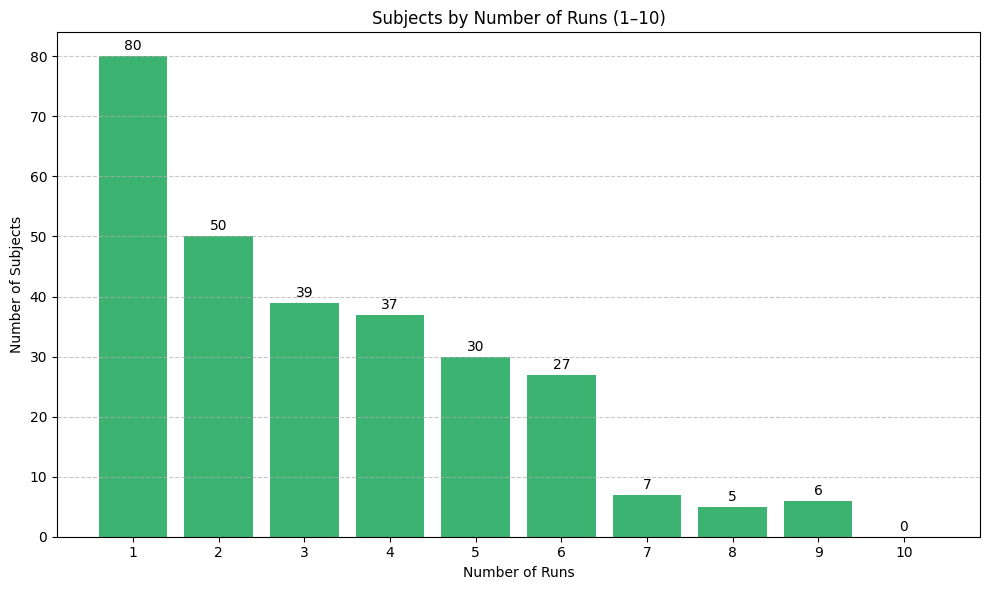

In [5]:
import os
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Set your folder path
drive_folder = '/content/drive/MyDrive/Data/Updated FC Matrices/DFC Matrices'

# Updated regex pattern for your filenames
pattern = r"sub-(\w+)_run-(\d+)_dynamic_fc_matrix\.npz"

# Dictionary to collect run numbers per subject
subject_runs = defaultdict(set)
matched_files = 0

# Scan files in the directory
for filename in os.listdir(drive_folder):
    match = re.match(pattern, filename)
    if match:
        subject_id, run_number = match.groups()
        subject_runs[subject_id].add(int(run_number))
        matched_files += 1

# Print diagnostics
print(f"Matched {matched_files} files.")
print(f"Number of unique subject IDs: {len(subject_runs)}")

# Count how many subjects have 1 to 10 runs
run_counts = Counter(len(runs) for runs in subject_runs.values())
all_run_counts = [run_counts.get(i, 0) for i in range(1, 11)]

# Plot the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 11), all_run_counts, color='mediumseagreen')

# Add count labels above each bar
for i, count in enumerate(all_run_counts, start=1):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Number of Runs')
plt.ylabel('Number of Subjects')
plt.title('Subjects by Number of Runs (1–10)')
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()